In [1]:
from GeneratorEncoderTriplets.encoder.data_processing import ImagesDataset, BalanceSamplerFilled
from GeneratorEncoderTriplets.encoder.loss_module import EPHNLoss
from StarGAN.stargan_v2.core.model import StyleEncoder
import torch
from torch import optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import pathlib
import time
import os
from matplotlib import pyplot as plt
from sklearn import manifold
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running device:', DEVICE)

Running device: cuda


In [3]:
train_transforms = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)
train_data_path = pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/dataset/train')

eval_transforms = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)
eval_data_path = pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/dataset/val')

In [4]:
len(os.listdir(train_data_path / 'normal')), len(os.listdir(train_data_path / 'cancer')), len(os.listdir(train_data_path / 'covid'))

(375, 505, 450)

In [5]:
len(os.listdir(eval_data_path / 'normal')), len(os.listdir(eval_data_path / 'cancer')), len(os.listdir(eval_data_path / 'covid'))

(41, 56, 50)

In [6]:
# encoder_model = StyleEncoder(
#     img_size=256,
#     style_dim=64,
#     num_domains=3
# )
encoder_model = models.resnet50(pretrained=True)
fc_in_features = encoder_model.fc.in_features
encoder_model.fc = torch.nn.Linear(in_features=fc_in_features, out_features=64)
# Possibly use pretrained from stargan-v2
encoder_model.to(DEVICE)

N_EPOCHS = 200
N_SIZE = 505
BATCH_SIZE = 128
NUM_WORKERS = 8
criterion = EPHNLoss()
criterion.semi = True
optimizer = optim.SGD(encoder_model.parameters(), lr=0.0005, momentum=0.0)
# Decay after 0.5 (50 in case of 100) * epochs and after 0.75 * epochs (75 in case of 100)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [int(N_EPOCHS * 0.5), int(N_EPOCHS * 0.75)], gamma=0.1)

In [7]:
next(iter(encoder_model.parameters())).requires_grad

True

In [8]:
eval_dataset = ImagesDataset(
    data_path=eval_data_path,
    images_transform=eval_transforms,
    target_transform=None
)
eval_sampler = BalanceSamplerFilled(intervals=eval_dataset.intervals, n_images=56)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, sampler=eval_sampler, num_workers=NUM_WORKERS)
print(len(eval_dataset), len(eval_loader), eval_dataset.class_to_idx)

147 2 {'cancer': 0, 'covid': 1, 'normal': 2}


In [9]:
torch.unique(next(iter(eval_loader))[1], return_counts=True), eval_dataset.class_to_idx

((tensor([0, 1, 2]), tensor([41, 39, 48])),
 {'cancer': 0, 'covid': 1, 'normal': 2})

In [10]:
dataset = ImagesDataset(
    data_path=train_data_path,
    images_transform=train_transforms,
    target_transform=None
)
sampler = BalanceSamplerFilled(intervals=dataset.intervals, n_images=N_SIZE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)

In [11]:
dataset.intervals, dataset.class_to_idx

([[0, 375], [375, 880], [880, 1330]], {'cancer': 0, 'covid': 1, 'normal': 2})

In [12]:
start_time = time.time()
global_iterations = 0
for epoch in tqdm(range(N_EPOCHS + 1)): 
    if epoch > 0:
        dataset = ImagesDataset(
            data_path=train_data_path,
            images_transform=train_transforms,
            target_transform=None
        )
        sampler = BalanceSamplerFilled(intervals=dataset.intervals, n_images=N_SIZE)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
        
        encoder_model.train()
 
        # record loss
        train_loss_accum = 0.0

        # iterate batch
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                # Image and its label
                # <FloatTensor> <LongTensor>
                # fvec is encoded vector
                fvec = encoder_model(x_batch)
                # Calculate EPHN Triplet NCA loss
                loss, Pos_log, Neg_log, margin = criterion(fvec, y_batch)
                loss.backward()
                optimizer.step() 
            # writer.add_histogram('Pos_hist', Pos_log, global_it)
            # writer.add_histogram('Neg_hist', Neg_log, global_it)
            # writer.add_scalar('Margin', margin, global_it)
            global_iterations += 1

            train_loss_accum += loss.item()
            # N_data += len(y_batch)
            
        # writer.add_scalar('loss', L_data/N_data, epoch)
        # adjust the learning rate
        scheduler.step()
    
        # evaluation phase
        if epoch % 2 == 0:
            encoder_model.eval()
            test_loss_accum = 0.0
            with torch.inference_mode():
                for test_x_batch, test_y_batch in eval_loader:
                    test_x_batch, test_y_batch = test_x_batch.to(DEVICE), test_y_batch.to(DEVICE)
                    test_fvec = encoder_model(test_x_batch)
                    test_loss, test_Pos_log, test_Neg_log, test_margin = criterion(test_fvec, test_y_batch)
                    test_loss_accum += test_loss.item()
            print(f'Epoch: {epoch} | Train loss: {train_loss_accum / len(loader)} | Test loss: {test_loss_accum / len(eval_loader)}')
end_time = time.time()
print('Total training time:', end_time - start_time)

  0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 2 | Train loss: 0.2969956696033478 | Test loss: 0.2875724583864212
Epoch: 4 | Train loss: 0.09269535976151626 | Test loss: 0.17352642863988876
Epoch: 6 | Train loss: 0.04666284751147032 | Test loss: 0.07865791767835617
Epoch: 8 | Train loss: 0.02999591773065428 | Test loss: 0.047037738375365734
Epoch: 10 | Train loss: 0.024171245361988742 | Test loss: 0.05984698049724102
Epoch: 12 | Train loss: 0.019689537041510146 | Test loss: 0.042636564001441
Epoch: 14 | Train loss: 0.015975150008065004 | Test loss: 0.041989379562437534
Epoch: 16 | Train loss: 0.01406903270011147 | Test loss: 0.04012106917798519
Epoch: 18 | Train loss: 0.011030190663101772 | Test loss: 0.03357477020472288
Epoch: 20 | Train loss: 0.011617851443588734 | Test loss: 0.03558462392538786
Epoch: 22 | Train loss: 0.009453930581609407 | Test loss: 0.02927297167479992
Epoch: 24 | Train loss: 0.006927025310384731 | Test loss: 0.029685580637305975
Epoch: 26 | Train loss: 0.006852596105697255 | Test loss: 0.02864225814118

In [13]:
triplets_encoder_path = pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/checkpoints/triplets_encoder_resnet50.pth')
with open(triplets_encoder_path, 'wb') as file:
    torch.save(encoder_model.state_dict(), file)

In [14]:
eval_dataset.class_to_idx

{'cancer': 0, 'covid': 1, 'normal': 2}

In [15]:
normal_example = eval_dataset[0]
cancer_example = eval_dataset[50]
covid_example = eval_dataset[100]

normal_example2 = eval_dataset[2]
cancer_example2 = eval_dataset[52]
covid_example2 = eval_dataset[102]

In [16]:
def extract_embedding(example: tuple, model: torch.nn.Module):
    model.eval()
    with torch.inference_mode():
        image, domain = example
        image, domain = image.unsqueeze(dim=0), torch.LongTensor([domain])
        image, domain = image.to(DEVICE), domain.to(DEVICE)
        return model(image)

In [17]:
normal_embedding = extract_embedding(normal_example, encoder_model)
cancer_embedding = extract_embedding(cancer_example, encoder_model)
covid_embedding = extract_embedding(covid_example, encoder_model)

In [18]:
normal_embedding2 = extract_embedding(normal_example2, encoder_model)
cancer_embedding2 = extract_embedding(cancer_example2, encoder_model)
covid_embedding2 = extract_embedding(covid_example2, encoder_model)

In [19]:
torch.sqrt(torch.sum((normal_embedding - cancer_embedding) ** 2))

tensor(2.0753, device='cuda:0')

In [20]:
torch.sqrt(torch.sum((covid_embedding - covid_embedding2) ** 2))

tensor(1.9084, device='cuda:0')

In [21]:
!nvidia-smi

Mon Nov  7 19:25:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:8B:00.0 Off |                    0 |
| N/A   37C    P0    38W / 250W |  16055MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
with torch.inference_mode():
    encoder_model.load_state_dict(torch.load(triplets_encoder_path))
    domains = []
    embeddings = []
    encoder_model.eval()
    for x_batch, y_batch in eval_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        f_vectors = encoder_model(x_batch)
        domains += y_batch.tolist()
        embeddings.append(f_vectors.cpu())
    embeddings = torch.concat(embeddings, dim=0)

In [23]:
tsne = manifold.TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(embeddings)

/home/natitov/miniforge/envs/hack_lct/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/natitov/miniforge/envs/hack_lct/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [24]:
eval_dataset.class_to_idx

{'cancer': 0, 'covid': 1, 'normal': 2}

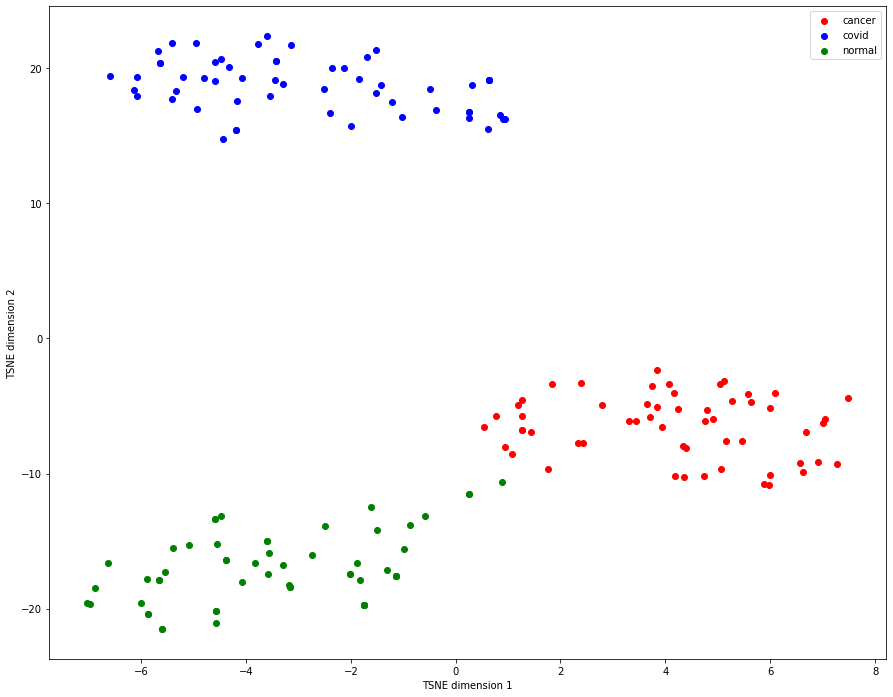

In [25]:
plt.figure(figsize=(15, 12))
domains = np.array(domains)
plt.scatter(tsne_embeddings[domains == 0][:, 0], tsne_embeddings[domains == 0][:, 1], c='red', label='cancer')
plt.scatter(tsne_embeddings[domains == 1][:, 0], tsne_embeddings[domains == 1][:, 1], c='blue', label='covid')
plt.scatter(tsne_embeddings[domains == 2][:, 0], tsne_embeddings[domains == 2][:, 1], c='green', label='normal')
plt.xlabel('TSNE dimension 1')
plt.ylabel('TSNE dimension 2')
plt.legend()
plt.grid(False);